In [17]:
import pandas as pd

file_path = 'bitcoin_sentiments_21_24.csv'  
data = pd.read_csv(file_path)

data = data[['Date', 'Short Description']].rename(columns={'Short Description': 'Description'})

data['Date'] = pd.to_datetime(data['Date']).dt.date

start_date = pd.to_datetime('2021-12-27').date()
end_date = pd.to_datetime('2023-12-19').date()

filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

filtered_data = filtered_data.reset_index(drop=True)

filtered_data 

,Date,Description
0,2021-12-27,Bitcoin price is showing positive signs near U...
1,2021-12-27,"'Illegal debt is not protected by law,' and a ..."
2,2021-12-27,There is a new Telegram malware which joins cr...
3,2021-12-27,"Get your daily, bite-sized digest of cryptoass..."
4,2021-12-28,Bitcoin price started a fresh decline from USD...
...,...,...
9837,2023-12-18,Bitcoin may remain under pressure for a few da...
9838,2023-12-19,The SEC has pushed back its decision on a rost...
9839,2023-12-19,Bitcoin's 150% surge pales in comparison to th...
9840,2023-12-19,Cathie Wood led ARK Invest fund sold around 80...


# cleaning

In [18]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

filtered_data['Cleaned_Description'] = filtered_data['Description'].apply(clean_text)

filtered_data[['Date', 'Cleaned_Description']].head()

,Date,Cleaned_Description
0,2021-12-27,bitcoin price is showing positive signs near u...
1,2021-12-27,illegal debt is not protected by law and a tok...
2,2021-12-27,there is a new telegram malware which joins cr...
3,2021-12-27,get your daily bitesized digest of cryptoasset...
4,2021-12-28,bitcoin price started a fresh decline from usd...


# stopwords

In [19]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    from nltk.tokenize import word_tokenize
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

filtered_data['No_Stopwords'] = filtered_data['Cleaned_Description'].apply(remove_stopwords)

In [20]:
filtered_data.head()

,Date,Description,Cleaned_Description,No_Stopwords
0,2021-12-27,Bitcoin price is showing positive signs near U...,bitcoin price is showing positive signs near u...,bitcoin price showing positive signs near usd ...
1,2021-12-27,"'Illegal debt is not protected by law,' and a ...",illegal debt is not protected by law and a tok...,illegal debt protected law token illegal objec...
2,2021-12-27,There is a new Telegram malware which joins cr...,there is a new telegram malware which joins cr...,new telegram malware joins cryptofocused group...
3,2021-12-27,"Get your daily, bite-sized digest of cryptoass...",get your daily bitesized digest of cryptoasset...,get daily bitesized digest cryptoasset blockch...
4,2021-12-28,Bitcoin price started a fresh decline from USD...,bitcoin price started a fresh decline from usd...,bitcoin price started fresh decline usd ethere...


# tokenization

In [21]:
from nltk.tokenize import word_tokenize
import nltk

def tokenize_text(text):
    return word_tokenize(text)

filtered_data['Tokenized'] = filtered_data['No_Stopwords'].apply(tokenize_text)

In [22]:
filtered_data[['No_Stopwords', 'Tokenized']].head()

,No_Stopwords,Tokenized
0,bitcoin price showing positive signs near usd ...,"[bitcoin, price, showing, positive, signs, nea..."
1,illegal debt protected law token illegal objec...,"[illegal, debt, protected, law, token, illegal..."
2,new telegram malware joins cryptofocused group...,"[new, telegram, malware, joins, cryptofocused,..."
3,get daily bitesized digest cryptoasset blockch...,"[get, daily, bitesized, digest, cryptoasset, b..."
4,bitcoin price started fresh decline usd ethere...,"[bitcoin, price, started, fresh, decline, usd,..."


# lemmatization

In [25]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(tokens):
    pos_tags = pos_tag(tokens) 
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

filtered_data['Lemmatized'] = filtered_data['Tokenized'].apply(lemmatize_text)
filtered_data['Lemmatized_Text'] = filtered_data['Lemmatized'].apply(lambda x: ' '.join(x))

In [26]:
filtered_data[['Tokenized', 'Lemmatized', 'Lemmatized_Text']].head()

,Tokenized,Lemmatized,Lemmatized_Text
0,"[bitcoin, price, showing, positive, signs, nea...","[bitcoin, price, show, positive, sign, near, u...",bitcoin price show positive sign near usd ethe...
1,"[illegal, debt, protected, law, token, illegal...","[illegal, debt, protect, law, token, illegal, ...",illegal debt protect law token illegal object ...
2,"[new, telegram, malware, joins, cryptofocused,...","[new, telegram, malware, join, cryptofocused, ...",new telegram malware join cryptofocused group ...
3,"[get, daily, bitesized, digest, cryptoasset, b...","[get, daily, bitesized, digest, cryptoasset, b...",get daily bitesized digest cryptoasset blockch...
4,"[bitcoin, price, started, fresh, decline, usd,...","[bitcoin, price, start, fresh, decline, usd, e...",bitcoin price start fresh decline usd ethereum...


# finbert etiketleme

In [28]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_sentiment_continuous(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()[0]
    sentiment_score = (-1 * probabilities[0]) + (0 * probabilities[1]) + (1 * probabilities[2])
    return sentiment_score

filtered_data['Sentiment_Score'] = filtered_data['Lemmatized_Text'].apply(analyze_sentiment_continuous)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [29]:
filtered_data[['Date','Sentiment_Score']]

,Date,Sentiment_Score
0,2021-12-27,0.999373
1,2021-12-27,-0.000036
2,2021-12-27,-0.988353
3,2021-12-27,-0.000029
4,2021-12-28,-0.997035
...,...,...
9837,2023-12-18,-0.996431
9838,2023-12-19,-0.118261
9839,2023-12-19,0.999132
9840,2023-12-19,-0.000034


filtered_data.to_csv("yeni_tarih_data.csv", index=False)

# granger

In [30]:
aggregated_sentiments = filtered_data.groupby('Date', as_index=False)['Sentiment_Score'].mean()

full_date_range = pd.date_range(start=aggregated_sentiments['Date'].min(), end=aggregated_sentiments['Date'].max(), freq='D')

aggregated_sentiments_full = pd.DataFrame({'Date': full_date_range})

aggregated_sentiments['Date'] = pd.to_datetime(aggregated_sentiments['Date'])
aggregated_sentiments_full['Date'] = pd.to_datetime(aggregated_sentiments_full['Date'])

aggregated_sentiments_full = pd.merge(aggregated_sentiments_full, aggregated_sentiments, on='Date', how='left')

aggregated_sentiments_full['Sentiment_Score'] = aggregated_sentiments_full['Sentiment_Score'].fillna(0)

aggregated_sentiments_full.head()

,Date,Sentiment_Score
0,2021-12-27,0.002739
1,2021-12-28,-0.679458
2,2021-12-29,-0.331525
3,2021-12-30,0.000629
4,2021-12-31,0.032116


In [31]:
import yfinance as yf

btc_data = yf.download('BTC-USD', start=aggregated_sentiments_full['Date'].min(), end=aggregated_sentiments_full['Date'].max() + pd.Timedelta(days=1))

btc_data = btc_data[['Close']].reset_index()

btc_data['Date'] = pd.to_datetime(btc_data['Date'])

btc_data['Change'] = btc_data['Close'].pct_change()*100 

final_data = pd.merge(aggregated_sentiments_full, btc_data, on='Date', how='left')

final_data['Change'] = final_data['Change'].fillna(0)

[*********************100%%**********************]  1 of 1 completed


In [52]:
final_data[["Date",	"Sentiment_Score","Close","Change"]]

,Date,Sentiment_Score,Close,Change
0,2021-12-27,0.002739,50640.417969,0.000000
1,2021-12-28,-0.679458,47588.855469,-6.025943
2,2021-12-29,-0.331525,46444.710938,-2.404228
3,2021-12-30,0.000629,47178.125000,1.579112
4,2021-12-31,0.032116,46306.445312,-1.847635
...,...,...,...,...
718,2023-12-15,0.232039,41929.757812,-2.543268
719,2023-12-16,0.001987,42240.117188,0.740189
720,2023-12-17,0.491095,41364.664062,-2.072563
721,2023-12-18,0.026618,42623.539062,3.043358


In [47]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

sentiment_series = final_data['Sentiment_Score']
btc_change_series = final_data['Change']

def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF istatistiği {name}: {result[0]}")
    print(f"p-değeri: {result[1]}")
    if result[1] < 0.1:
        print(f"{name} durağandır.")
    else:
        print(f"{name} durağan değildir.")

adf_test(sentiment_series, "Sentiment_Score")
adf_test(btc_change_series, "Change")

ADF istatistiği Sentiment_Score: -6.419844639149055
p-değeri: 1.8028935264331482e-08
Sentiment_Score durağandır.
ADF istatistiği Change: -26.71914494050214
p-değeri: 0.0
Change durağandır.


In [48]:
from statsmodels.tsa.stattools import grangercausalitytests

data_for_granger = final_data[['Change','Sentiment_Score']]

max_lag = 5
result = grangercausalitytests(data_for_granger, maxlag=max_lag, verbose=False)

results_table = []
for lag in range(1, max_lag + 1):
    f_test_stat = result[lag][0]['ssr_ftest'][0]
    f_test_p_value = result[lag][0]['ssr_ftest'][1]
    
    results_table.append({
        "Lag": lag,
        "F-Test Stat": f_test_stat,
        "F-Test P-Value": f_test_p_value,
    })

results_df = pd.DataFrame(results_table)
results_df

C:\Users\ilker\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,Lag,F-Test Stat,F-Test P-Value
0,1,3.628085,0.057211
1,2,3.953125,0.019615
2,3,2.757982,0.041451
3,4,2.082520,0.081408
4,5,1.678895,0.137347


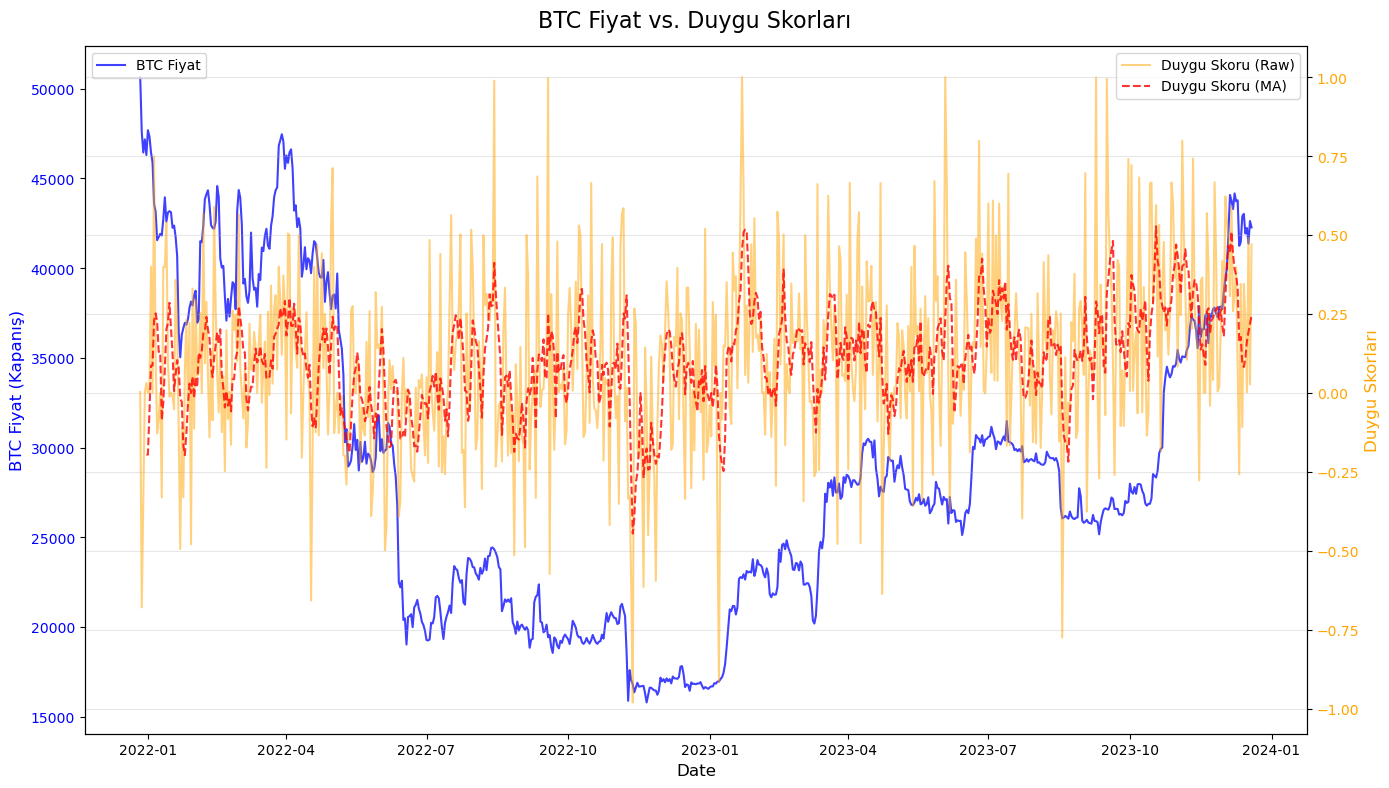

In [51]:
import matplotlib.pyplot as plt

final_data['Sentiment_Score_MA'] = final_data['Sentiment_Score'].rolling(window=5).mean() 

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('BTC Fiyat (Kapanış)', color='blue', fontsize=12)
ax1.plot(final_data['Date'], final_data['Close'], label='BTC Fiyat', color='blue', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Duygu Skorları', color='orange', fontsize=12)
ax2.plot(final_data['Date'], final_data['Sentiment_Score'], label='Duygu Skoru (Raw)', color='orange', alpha=0.5)
ax2.plot(final_data['Date'], final_data['Sentiment_Score_MA'], label='Duygu Skoru (MA)', color='red', alpha=0.8, linestyle='--')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right', fontsize=10)

fig.suptitle('BTC Fiyat vs. Duygu Skorları', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()